In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate, InputLayer
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import random
import cv2
from PIL import Image

In [ ]:
# Reading the dataset
dataset = pd.read_csv('creditcard.csv')
dataset.head(20)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


### Check for imbalancedness


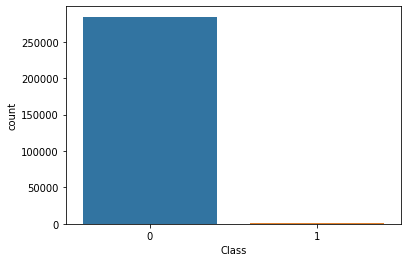

In [ ]:
# Check for imbalencedness
sns.countplot(x='Class',data=dataset)
# The dataset is very imbalanced, this gives the possibilty to do anomaly detection.

In [ ]:
dataset[dataset.isnull().any(axis=1)]
#No rows with nan values

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


In [ ]:
# Split into training set and test set.
fraud = dataset[dataset.Class == 1]
clean = dataset[dataset.Class == 0]
# Only class 1 rows to train and learn what anomaly looks like
X_train = clean.iloc[:int(len(dataset)*0.80)].drop('Class', axis=1)

# Both class 0 and 1 rows to test with
X_test = clean.iloc[int(len(dataset)*0.80):].append(fraud).sample(frac=1)
X_test, y_test = X_test.drop('Class', axis=1).values, X_test.Class.values

In [ ]:
#Normalise  features.
scaler = preprocessing.MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train[0].shape

(30,)

In [ ]:
# Training an undercomplete autoencoder to learn the features of the fraud transactions.
def train():
    input_shape = Input(shape=(30,))
    adam = tf.keras.optimizers.Adam(0.01)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    model = Sequential()
    #Encoder
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    #Decoder
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(30, activation='sigmoid'))


    model.compile(optimizer=adam,loss='mean_squared_error')


    history=model.fit(X_train, X_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True, callbacks=[es])
    return model, history

In [ ]:
model, history=train()

### Evaluate

In [ ]:
pred = model.predict(X_test)

In [ ]:
mse = np.mean(np.power(X_test - pred, 2), axis=1)

In [ ]:
error_df = pd.DataFrame({'Error': mse,
                        'True_class': y_test})

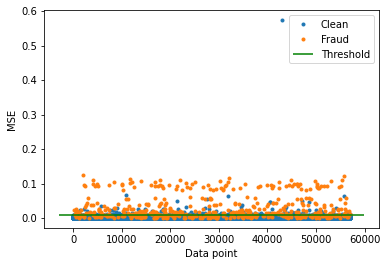

In [ ]:
# Plot the transactions together with the threshold value, if the error is higher than the threshold value, it is considered as fraud.
threshold = 0.015
classes = error_df.groupby('True_class')
fig, ax = plt.subplots()
#Plot each point
for name, group in classes:
    ax.plot(group.index, group.Error, marker='o', ms=3, linestyle='',
            label= "Fraud" if name == 1 else "Clean")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="g", zorder=100, label='Threshold')

ax.legend()
plt.ylabel("MSE")
plt.xlabel("Data point")
plt.show();

In [ ]:
outliers = mse > 0.015

In [ ]:
print('\n')
print(classification_report(y_test, outliers))

cf = confusion_matrix(y_test, outliers)

print(cf)
print(accuracy_score(y_test, outliers) * 100)
#In the end the model is able to detect the about half fraud transactions. depending on the use case the threshold value can be highered or lowered. Lowering threshold will improve the recall but decrease the precision.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56470
           1       0.80      0.49      0.61       492

    accuracy                           0.99     56962
   macro avg       0.90      0.75      0.80     56962
weighted avg       0.99      0.99      0.99     56962

[[56408    62]
 [  249   243]]
99.45402197956533


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:429: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


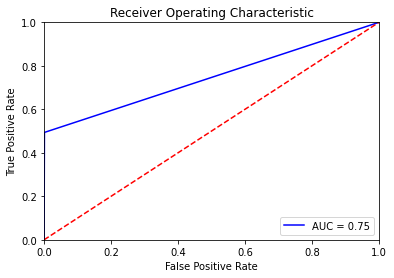

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test, outliers)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#There is 75% chance that a random fraud value will be correctly classified. The higher the AUC, the better the model is at telling apart 0 and 1 classes.

In [ ]:
#To reduce false negatives we can use a even lower threshold
outliers = mse > 0.01
print('\n')
print(classification_report(y_test, outliers))

cf = confusion_matrix(y_test, outliers)

print(cf)
print(accuracy_score(y_test, outliers) * 100) 



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56470
           1       0.65      0.63      0.64       492

    accuracy                           0.99     56962
   macro avg       0.82      0.81      0.82     56962
weighted avg       0.99      0.99      0.99     56962

[[56301   169]
 [  184   308]]
99.38028861346162


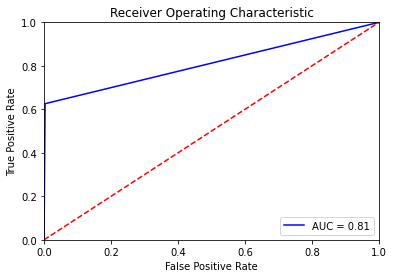

In [ ]:
#This ofcourse also improves the AUC score.
fpr, tpr, threshold = metrics.roc_curve(y_test, outliers)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()